In [1]:
%matplotlib inline
%run notebook_setup

## Cross validation

In this tutorial, we'll design and optimize a more sophisticated imaging workflow. Cross validation will help us build confidence that we are setting the regularization hyperparameters appropriately.

# Setup

We'll continue with the same central channel of the ALMA logo measurement set as before. If these commands don't make sense, please consult the previous tutorials.

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

In [3]:
import torch
from astropy.io import fits
from astropy.utils.data import download_file
from torch.utils.tensorboard import SummaryWriter

from mpol import (
    connectors,
    coordinates,
    datasets,
    gridding,
    images,
    losses,
    precomposed,
)

# load the mock dataset of the ALMA logo
fname = download_file(
    "https://zenodo.org/record/4930016/files/logo_cube.noise.npz",
    cache=True,
    show_progress=True,
    pkgname="mpol",
)

# this is a multi-channel dataset... for demonstration purposes we'll use
# only the central, single channel
chan = 4
d = np.load(fname)
uu = d["uu"][chan]
vv = d["vv"][chan]
weight = d["weight"][chan]
data = d["data"][chan]
data_re = np.real(data)
data_im = np.imag(data)

# define the image dimensions, making sure they are big enough to fit all
# of the expected emission
coords = coordinates.GridCoords(cell_size=0.03, npix=180)
gridder = gridding.Gridder(
    coords=coords, uu=uu, vv=vv, weight=weight, data_re=data_re, data_im=data_im
)

# export to PyTorch dataset
dset = gridder.to_pytorch_dataset()

Text(0, 0.5, '$\\Delta \\delta$ [${}^{\\prime\\prime}$]')

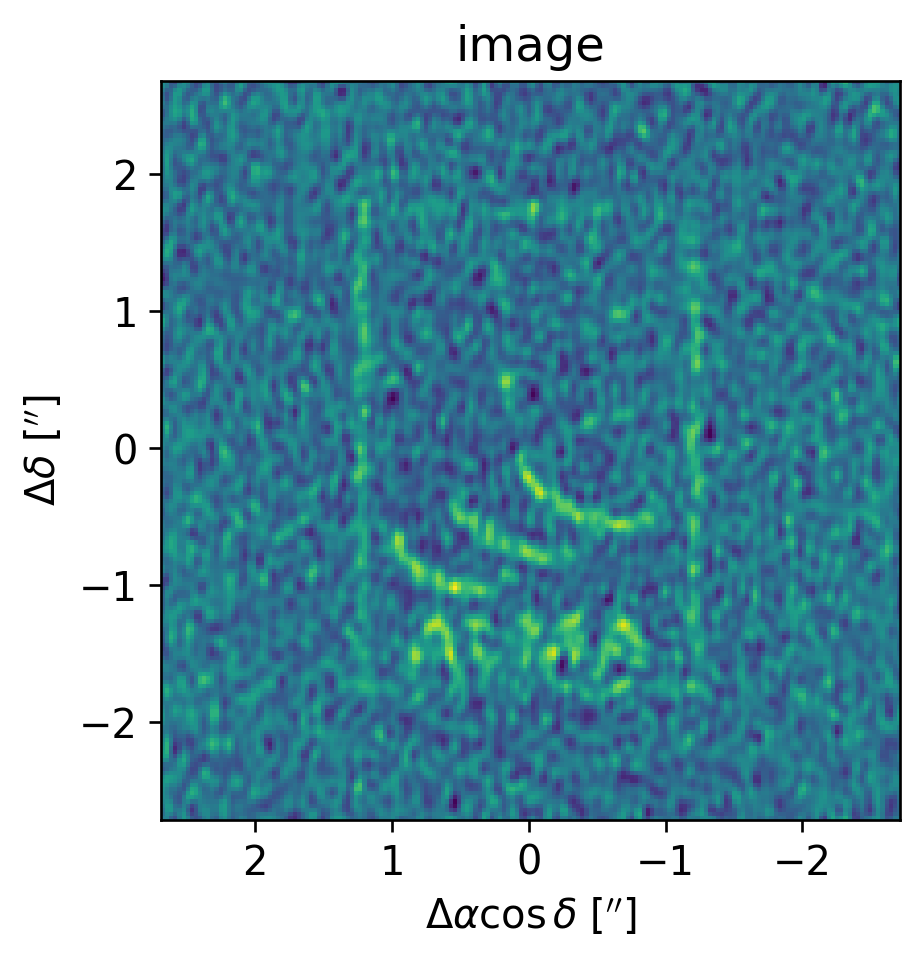

In [4]:
# Show the dirty image
img, beam = gridder.get_dirty_image(weighting="briggs", robust=0.0)
kw = {"origin": "lower", "extent": gridder.coords.img_ext}
fig, ax = plt.subplots(ncols=1)
ax.imshow(np.squeeze(img), **kw)
ax.set_title("image")
ax.set_xlabel(r"$\Delta \alpha \cos \delta$ [${}^{\prime\prime}$]")
ax.set_ylabel(r"$\Delta \delta$ [${}^{\prime\prime}$]")

# K-fold cross validation

[K-fold cross validation](https://en.wikipedia.org/wiki/Cross-validation_(statistics)) is a technique used to assess model validity. In the context of RML imaging, we use "model" to describe a whole host of assumptions inherent to the imaging workflow. Model settings include the ``cell_size``, the number of pixels, the mapping of the BaseCube to the ImageCube, as well as hyperparameter choices like the strength of the regularizer terms for each type of loss function. Usually we're most interested in assessing whether we have adequately set hyperparameters (like in this tutorial), but sometimes we'd like to assess model settings too.

If you're coming from astronomy or astrophysics, you might be most familiar with doing [Bayesian parameter inference](https://ui.adsabs.harvard.edu/abs/2019arXiv190912313S/abstract) with all of the data at once. In a typical workflow, you might implicitly assume that your model is valid and explore the shape of the unnormalized posterior distribution using a standard MCMC technique like Metropolis-Hastings. If you did want to compare the validity of models, then you would need to use a sampler which computes the Bayesian evidence, or posterior normalization.

But if you're coming from the machine learning community, you're most likely already familiar from the concept of optimizing your model using a "training" dataset and the assessing how well it does using a "test" or "validation" dataset. Astrophysical datasets are typically hard-won, however, so it's not often that we have a sizeable chunk of data lying around to use as a test set *in addition to* what we want to incorporate into our training dataset.

$K$-fold cross validation helps alleviate this concern somewhat by rotating testing/training chunks through the dataset. To implement $K$-fold cross validation, first split your dataset into $K$ (approximately equal) chunks. Then, do the following $K$ times:

* store one chunk ($1/K$th of the total data) separately as a test dataset
* combine the remaining chunks ($(K-1)/K$ of the total data set) into one dataset and use this to train the model
* use this model to predict the values of the data in the test dataset
* assess the difference between predicted test data and actual test data using a $\chi^2$ metric, called the cross-validation score

When all loops are done, you can average the $K$ cross-validation scores together into a final score for that model configuration. Lower cross validation scores are better in the sense that the trained model did a better job predicting the test data.

**Why does this work?** Cross validation is such a useful tool because it tells us how well a model generalizes to new data, with the idea being that a better model will predict new data more accurately. Some more considered thoughts on cross validation and model fitting are in [Hogg and Villar](https://ui.adsabs.harvard.edu/abs/2021arXiv210107256H/abstract).

# Choosing the $K$-folds

There are many ways to split a dataset into $K$ chunks, and, depending on your application, some schemes are better than others. For most interferometric datasets, visibility samples are clustered in Fourier space due to the limitations on the number and location of the antennas. One objective of cross validation might be figuring out how sparse $u$,$v$ coverage adversely affects our imaging process---ideally we'd like to tune the algorithm such that we would still recover a similar image even if our $u$,$v$ sampling were different. To explore slicing choices, here is the full $u$,$v$ coverage of our ALMA logo mock dataset (C43-7, 1 hour observation)

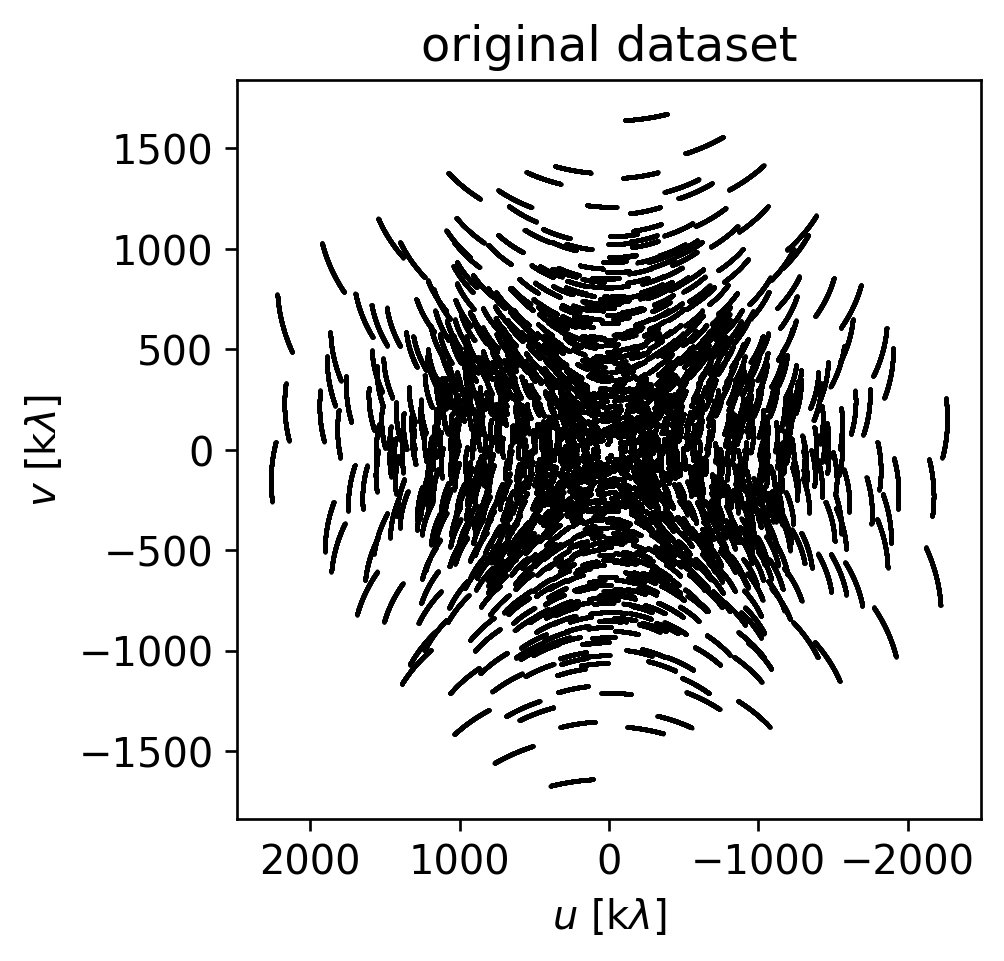

In [5]:
fig, ax = plt.subplots(nrows=1)
ax.scatter(uu, vv, s=1.5, rasterized=True, linewidths=0.0, c="k")
ax.scatter(
    -uu, -vv, s=1.5, rasterized=True, linewidths=0.0, c="k"
)  # and Hermitian conjugates
ax.set_xlabel(r"$u$ [k$\lambda$]")
ax.set_ylabel(r"$v$ [k$\lambda$]")
ax.set_title("original dataset")
ax.invert_xaxis()

As you can see, the $u$,$v$ space is sampled in a very structured way:

1. there are no samples at very low spatial frequencies (the center of the image, $< 10$ k$\lambda$)
2. most samples like at intermediate spatial frequencies (100 k$\lambda$ to 800 k$\lambda$)
3. there are very few samples at high spatial frequencies ($>$ 1000 k$\lambda$)
4. there are large gaps in the $u$,$v$ coverage where there are no visibilities, especially at high spatial frequencies

If we were to just draw randomly from these visibilities, because there are so many ($>$ 500,000 just in this single-channel figure), we would end up mostly replicating the same structured pattern in $u$,$v$. For example, here is what random training set might look like if $K=10$

650160 visibilities total


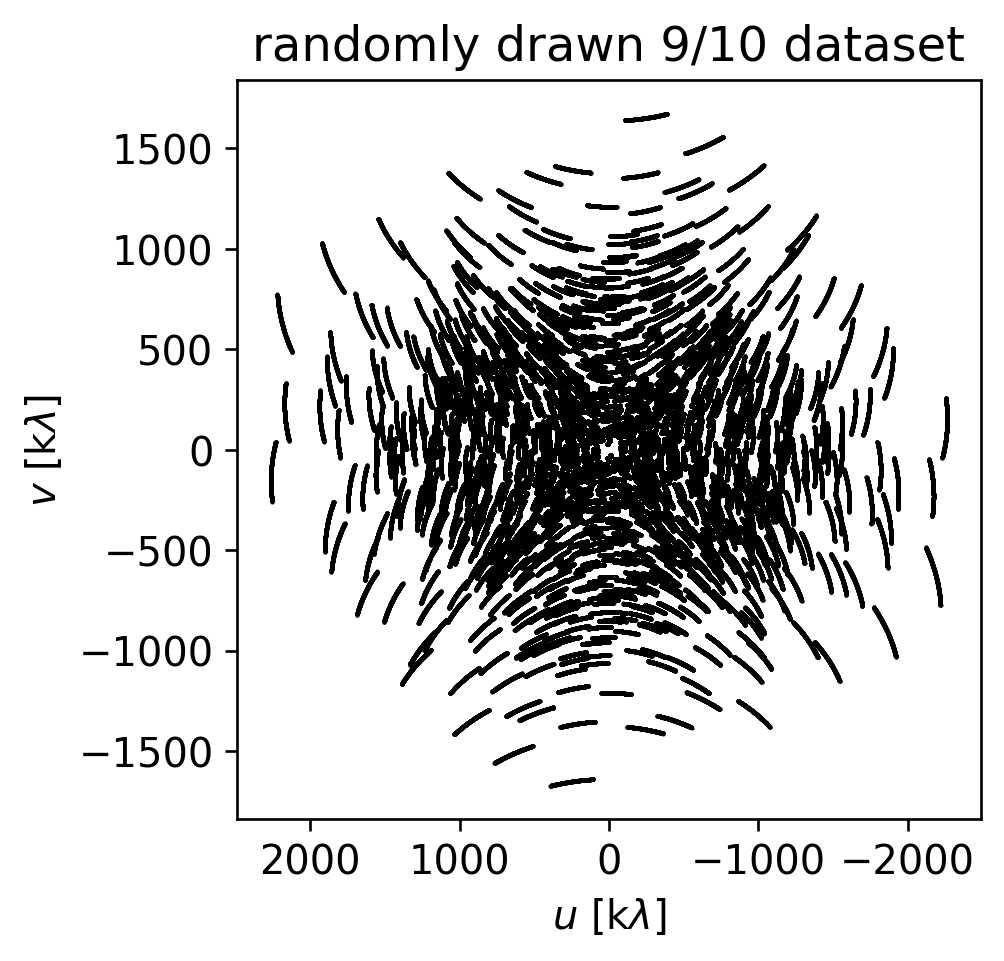

In [6]:
nvis = len(uu)
print(2 * nvis, "visibilities total")
ind = np.random.choice(np.arange(nvis), size=int(9 * nvis / 10), replace=False)

uk = uu[ind]
vk = vv[ind]

fig, ax = plt.subplots(nrows=1)
ax.scatter(uk, vk, s=1.5, rasterized=True, linewidths=0.0, c="k")
ax.scatter(
    -uk, -vk, s=1.5, rasterized=True, linewidths=0.0, c="k"
)  # and Hermitian conjugates
ax.set_xlabel(r"$u$ [k$\lambda$]")
ax.set_ylabel(r"$v$ [k$\lambda$]")
ax.set_title("randomly drawn 9/10 dataset")
ax.invert_xaxis()

As you can see, this training set looks very similar to the full dataset, with the same holes in $u$,$v$ coverage and similar sampling densities.

It turns out that the missing holes in the real dataset are quite important to image fidelity---if we had complete $u$,$v$ coverage, we wouldn't need to be worrying about CLEAN or RML imaging techniques in the first place! When we make a new interferometric observation, it will have it's own (different) set of missing holes depending on array configuration, observation duration, and hour angle coverage. We would like our cross validation slices to simulate the $u$,$v$ distribution of possible *new datasets*, and, at least for ALMA, random sampling doesn't probe this very well.

Instead, we suggest an approach where we break the UV plane into radial ($q=\sqrt{u^2 + v^2}$) and azimuthal ($\phi = \mathrm{arctan2}(v,u)$) cells and cross validate by drawing a $K$-fold subselection of these cells. This is just one potential suggestion. There are, of course, no limits on how you might split your dataset for cross-validation; it really depends on what works best for your imaging goals.

In [7]:
# create a radial and azimuthal partition
dartboard = datasets.Dartboard(coords=coords)

# create cross validator using this "dartboard"
k = 5
cv = datasets.KFoldCrossValidatorGridded(dset, k, dartboard=dartboard, npseed=42)

# ``cv`` is a Python iterator, it will return a ``(train, test)`` pair of ``GriddedDataset``s for each iteration.
# Because we'll want to revisit the individual datasets
# several times in this tutorial, we're storeing them into a list
k_fold_datasets = [(train, test) for (train, test) in cv]

In [8]:
flayer = images.FourierCube(coords=coords)
flayer.forward(torch.zeros(dset.nchan, coords.npix, coords.npix))

tensor([[[0.+0.j, 0.+0.j, 0.+0.j,  ..., 0.+0.j, 0.+0.j, 0.+0.j],
         [0.+0.j, 0.+0.j, 0.+0.j,  ..., 0.+0.j, 0.+0.j, 0.+0.j],
         [0.+0.j, 0.+0.j, 0.+0.j,  ..., 0.+0.j, 0.+0.j, 0.+0.j],
         ...,
         [0.+0.j, 0.+0.j, 0.+0.j,  ..., 0.+0.j, 0.+0.j, 0.+0.j],
         [0.+0.j, 0.+0.j, 0.+0.j,  ..., 0.+0.j, 0.+0.j, 0.+0.j],
         [0.+0.j, 0.+0.j, 0.+0.j,  ..., 0.+0.j, 0.+0.j, 0.+0.j]]])

The following plots visualize how we've split up the data. For each $K$-fold, we have the "training" visibilities, the dirty image corresponding to those training visibilities, and the "test" visibilities which will be used to evaluate the predictive ability of the model.

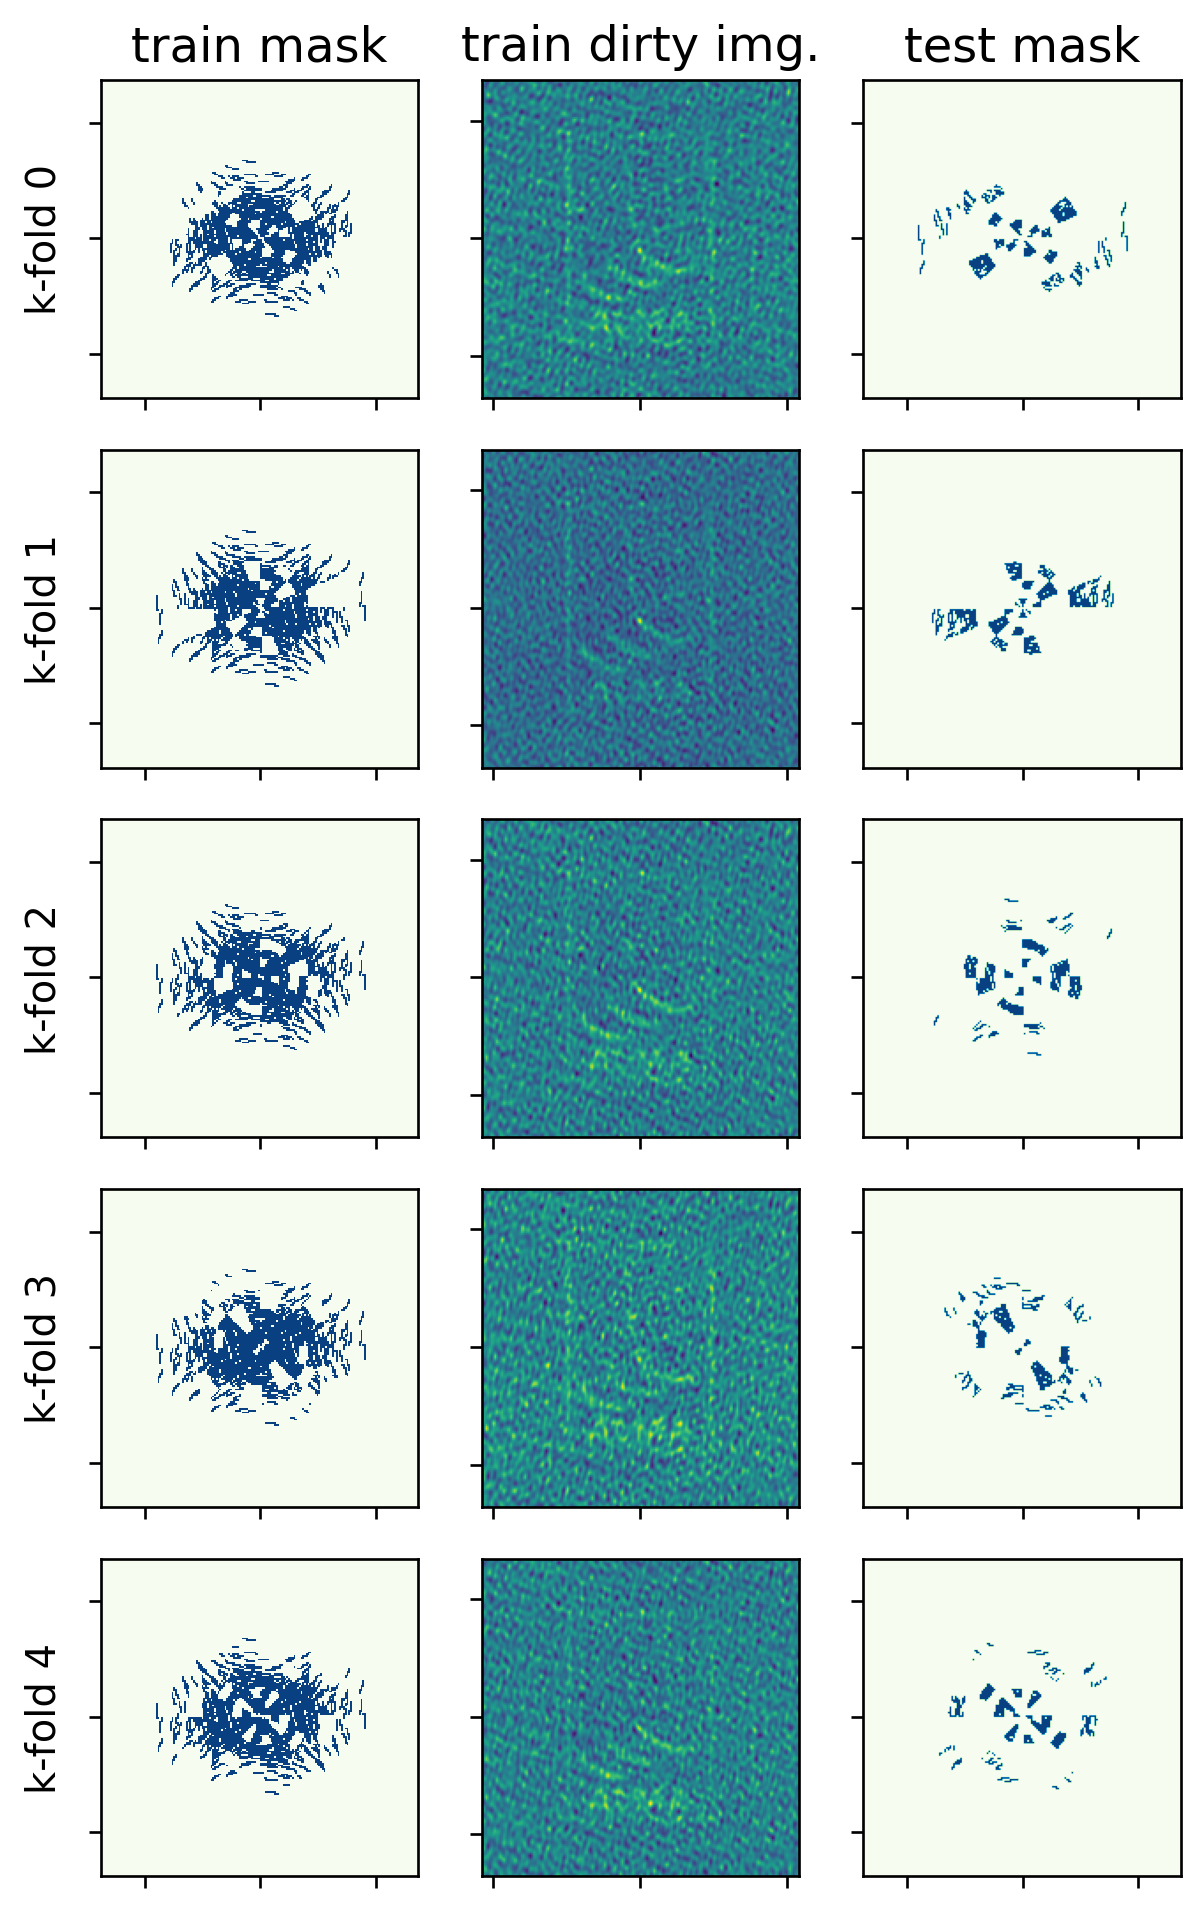

In [9]:
fig, ax = plt.subplots(nrows=k, ncols=3, figsize=(6, 10))

for i, (train, test) in enumerate(k_fold_datasets):

    rtrain = connectors.GriddedResidualConnector(flayer, train)
    rtrain.forward()
    rtest = connectors.GriddedResidualConnector(flayer, test)
    rtest.forward()

    vis_ext = rtrain.coords.vis_ext
    img_ext = rtrain.coords.img_ext

    train_mask = rtrain.ground_mask[0]
    train_chan = rtrain.sky_cube[0]

    test_mask = rtest.ground_mask[0]
    test_chan = rtest.sky_cube[0]

    ax[i, 0].imshow(
        train_mask.detach().numpy(),
        interpolation="none",
        origin="lower",
        extent=vis_ext,
        cmap="GnBu",
    )

    ax[i, 1].imshow(train_chan.detach().numpy(), origin="lower", extent=img_ext)

    ax[i, 2].imshow(
        test_mask.detach().numpy(), origin="lower", extent=vis_ext, cmap="GnBu"
    )

    ax[i, 0].set_ylabel("k-fold {:}".format(i))

ax[0, 0].set_title("train mask")
ax[0, 1].set_title("train dirty img.")
ax[0, 2].set_title("test mask")

for a in ax.flatten():
    a.xaxis.set_ticklabels([])
    a.yaxis.set_ticklabels([])

fig.subplots_adjust(left=0.15, hspace=0.0, wspace=0.2)

# The cross validation loop

Building on the previous optimization tutorial, we'll wrap the iterative optimization commands into a training function. This will come in handy, because we'll want to train the model on each of the varied $K$-fold training datasets. In this tutorial, we'll use a loss function of the form

$$
f_\mathrm{loss} = f_\mathrm{nll} + \lambda_\mathrm{sparsity} f_\mathrm{sparsity} + \lambda_{TV} f_\mathrm{TV}
$$
where the $\lambda$ prefactors are the strength of the regularization terms.

In [10]:
def train(model, dset, config, optimizer, writer=None):
    model.train()  # set to training mode

    for i in range(config["epochs"]):
        model.zero_grad()

        # get the predicted model
        vis = model.forward()

        # get the sky cube too
        sky_cube = model.icube.sky_cube

        # calculate a loss
        loss = (
            losses.nll_gridded(vis, dset)
            + config["lambda_sparsity"] * losses.sparsity(sky_cube)
            + config["lambda_TV"] * losses.TV_image(sky_cube)
        )

        if writer is not None:
            writer.add_scalar("loss", loss.item(), i)

        # calculate gradients of parameters
        loss.backward()

        # update the model parameters
        optimizer.step()

We also create a separate "test" function to evaluate the trained model against a set of witheld "test" visibilities.

In [11]:
def test(model, dset):
    model.train(False)
    # evaluate test score
    vis = model.forward()
    loss = losses.nll_gridded(vis, dset)
    return loss.item()

Finally, we put the $K$-fold iterator, the training function, and test function together into a cross validation training loop. For each $K$-fold, we

1. initialize the model and optimizer from scratch
2. fully train the model on the "train" slice
3. calculate the predictive power of that model on the "test" slice via a cross-validation metric

when all $K$-folds have been iterated through, we sum the individual cross validations scores into a total cross-validation metric for those hyperparameters.

In [12]:
def cross_validate(config):
    """
    config is a dictionary that should contain ``lr``, ``lambda_sparsity``, ``lambda_TV``, ``epochs``
    """
    test_scores = []

    for k_fold, (train_dset, test_dset) in enumerate(k_fold_datasets):

        # create a new model and optimizer for this k_fold
        rml = precomposed.SimpleNet(coords=coords, nchan=train_dset.nchan)
        optimizer = torch.optim.Adam(rml.parameters(), lr=config["lr"])

        # train for a while
        train(rml, train_dset, config, optimizer)
        # evaluate the test metric
        test_scores.append(test(rml, test_dset))

    # aggregate all test scores and sum to evaluate cross val metric
    test_score = np.sum(np.array(test_scores))

    return test_score

Finally, we'll write one more function to train the model using the full dataset.

In [13]:
def train_and_image(pars):
    rml = precomposed.SimpleNet(coords=coords, nchan=dset.nchan)
    optimizer = torch.optim.Adam(rml.parameters(), lr=pars["lr"])
    writer = SummaryWriter()
    train(rml, dset, pars, optimizer, writer=writer)
    writer.close()

    img_ext = rml.coords.img_ext
    fig, ax = plt.subplots()
    ax.imshow(
        np.squeeze(rml.icube.sky_cube.detach().numpy()), origin="lower", extent=img_ext
    )
    return fig, ax

All of the method presented here can be sped up using GPU acceleration on certain Nvidia GPUs. To learn more about this, please see the [GPU Setup Tutorial](gpu_setup.html).

# Results

As a starting point, we'll try cross-validating without any regularization.

/opt/hostedtoolcache/Python/3.8.11/x64/lib/python3.8/site-packages/torch/autograd/__init__.py:147: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at  /pytorch/aten/src/ATen/native/Copy.cpp:240.)
  Variable._execution_engine.run_backward(


Cross validation score: 36.80444112433067


(<Figure size 480x480 with 1 Axes>, <AxesSubplot:>)

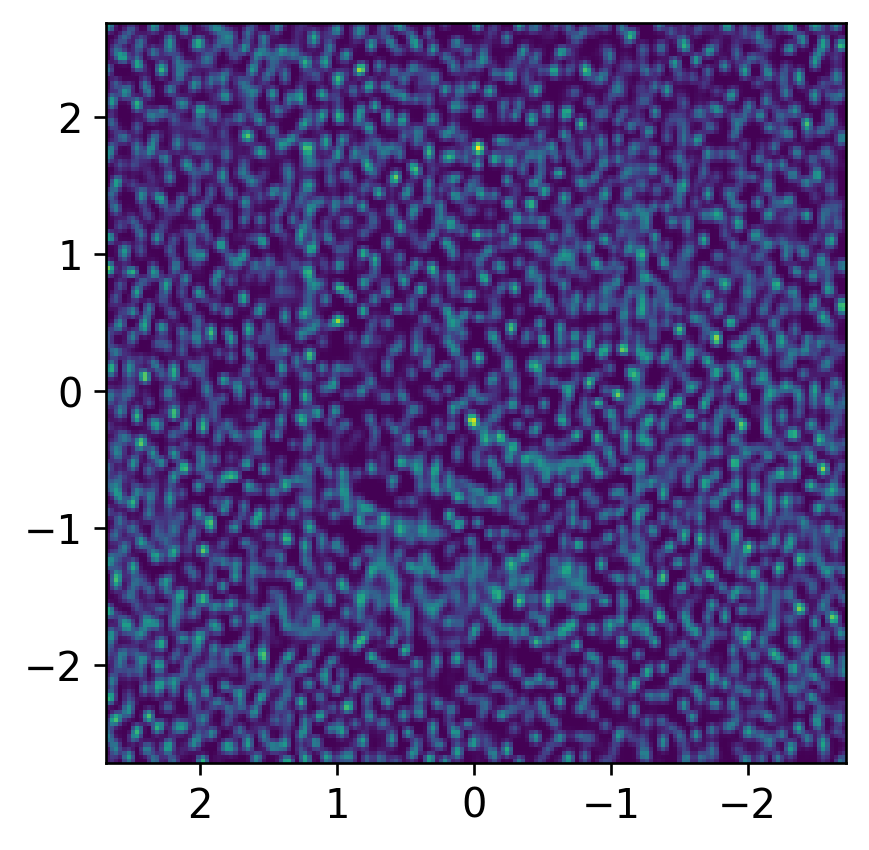

In [14]:
pars = {"lr": 0.5, "lambda_sparsity": 0, "lambda_TV": 0, "epochs": 600}
print("Cross validation score:", cross_validate(pars))
train_and_image(pars)

This image looks only slightly better than the dirty image itself. This is because it is nearly equivalent, the only difference is the baked-in regularization provided by our non-negative pixels. Next, let's try a small level of regularization

Cross validation score: 14.431548643548894


(<Figure size 480x480 with 1 Axes>, <AxesSubplot:>)

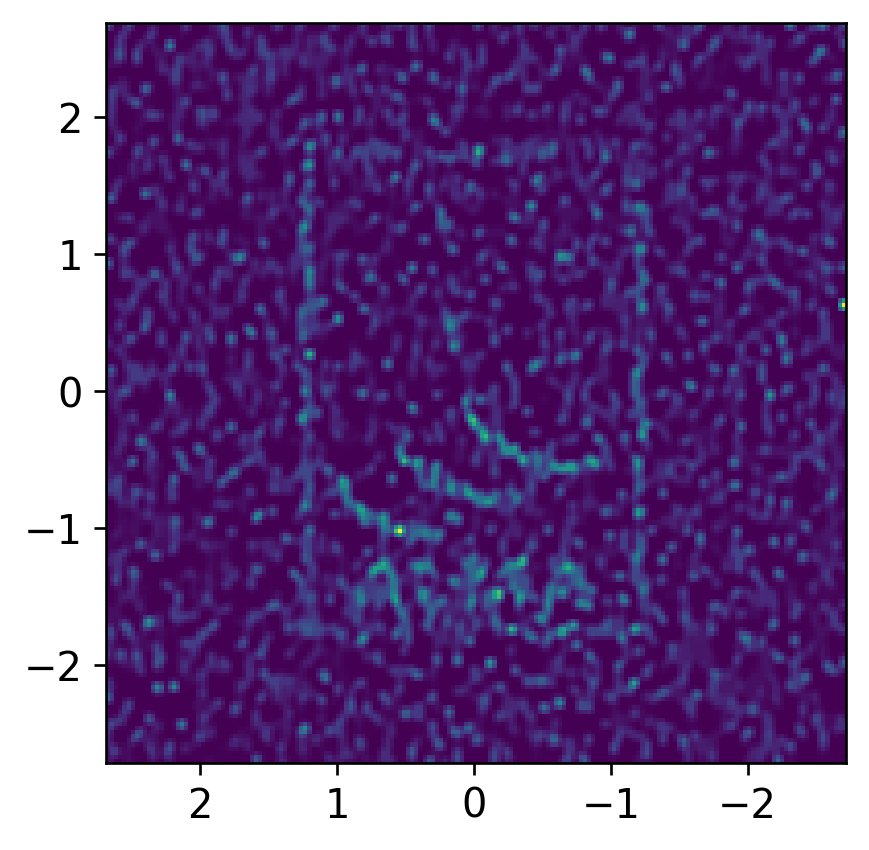

In [15]:
pars = {"lr": 0.5, "lambda_sparsity": 1e-5, "lambda_TV": 1e-5, "epochs": 600}
print("Cross validation score:", cross_validate(pars))
train_and_image(pars)

We see that the cross validation score improved significantly, meaning that these hyperparameter settings produce models that do a better job generalizing to new data. And, we can keep tweaking the hyperparameters to see how low of a cross-validation metric we can find.

Cross validation score: 7.660895815561863


(<Figure size 480x480 with 1 Axes>, <AxesSubplot:>)

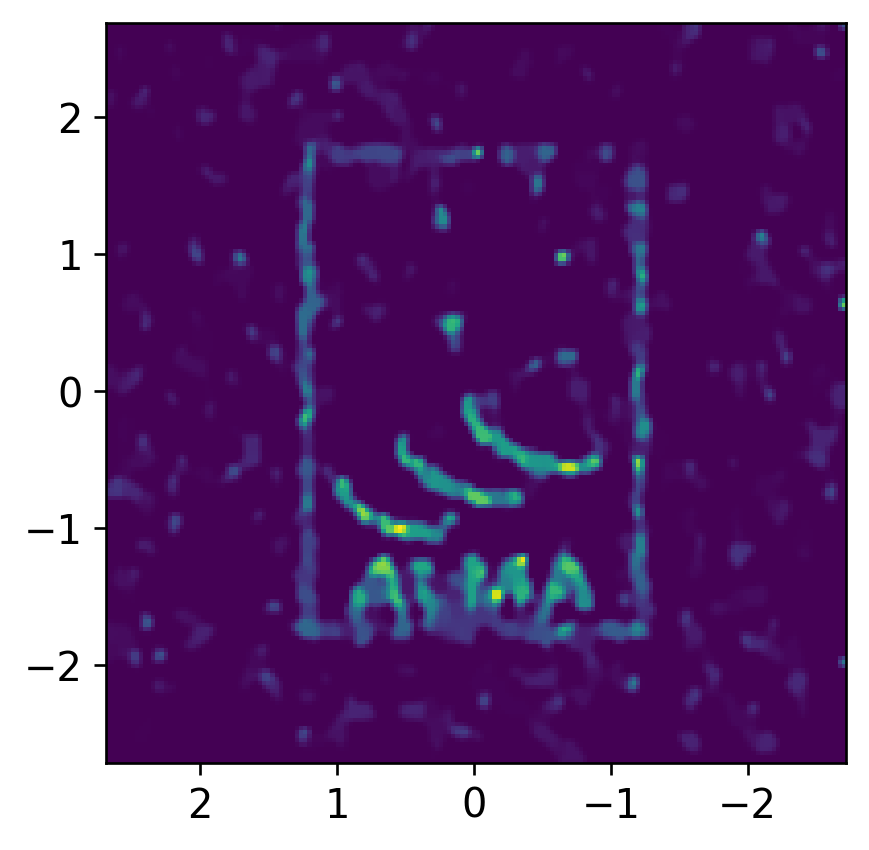

In [16]:
pars = {"lr": 0.5, "lambda_sparsity": 1e-4, "lambda_TV": 1e-4, "epochs": 600}
print("Cross validation score:", cross_validate(pars))
train_and_image(pars)

More regularizing strength doesn't always mean better... there will reach a point where the regularizing terms are strong that the model starts ignoring the data (via the ``nll_gridded`` term). To help you perform a full hyperparameter sweep and identify the "best" settings quickly, we recommend checking out tools like [Tensorboard](https://pytorch.org/docs/stable/tensorboard.html) and [Ray Tune](https://docs.ray.io/en/master/tune/index.html).

For the purposes of comparison, here is the image produced by the tclean algorithm using CASA. The full commands are in the [mpoldatasets](https://github.com/MPoL-dev/mpoldatasets/blob/main/products/ALMA-logo/tclean-iter.py) package.

In [17]:
fname = download_file(
    "https://zenodo.org/record/4930016/files/logo_cube.tclean.fits",
    cache=True,
    show_progress=True,
    pkgname="mpol",
)

In [18]:
hdul = fits.open(fname)
header = hdul[0].header
data = 1e3 * hdul[0].data[4]  # mJy/pixel
# get the coordinate labels
nx = header["NAXIS1"]
ny = header["NAXIS2"]
# RA coordinates
CDELT1 = 3600 * header["CDELT1"]  # arcsec (converted from decimal deg)
# DEC coordinates
CDELT2 = 3600 * header["CDELT2"]  # arcsec
RA = (np.arange(nx) - nx / 2) * CDELT1  # [arcsec]
DEC = (np.arange(ny) - ny / 2) * CDELT2  # [arcsec]
# extent needs to include extra half-pixels.
# RA, DEC are pixel centers
ext = (
    RA[0] - CDELT1 / 2,
    RA[-1] + CDELT1 / 2,
    DEC[0] - CDELT2 / 2,
    DEC[-1] + CDELT2 / 2,
)  # [arcsec]
norm = matplotlib.colors.Normalize(vmin=0, vmax=np.max(data))

Text(0, 0.5, '$\\Delta \\delta$ [${}^{\\prime\\prime}$]')

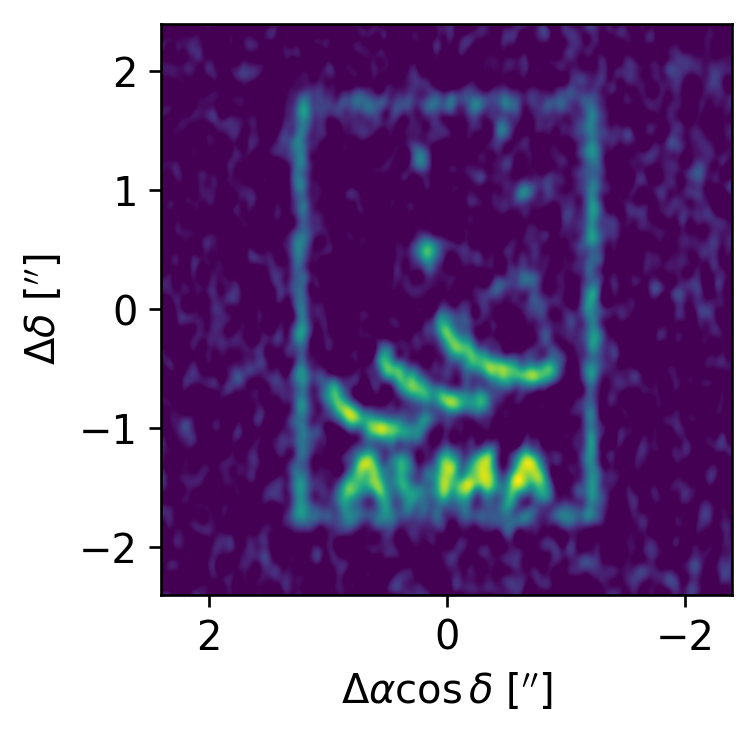

In [19]:
fig, ax = plt.subplots(nrows=1, figsize=(4.5, 3.5))
fig.subplots_adjust(left=0.2, bottom=0.2)
im = ax.imshow(data, extent=ext, origin="lower", animated=True, norm=norm)
r = 2.4
ax.set_xlim(r, -r)
ax.set_ylim(-r, r)
ax.set_xlabel(r"$\Delta \alpha \cos \delta$ [${}^{\prime\prime}$]")
ax.set_ylabel(r"$\Delta \delta$ [${}^{\prime\prime}$]")